In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [2]:
plt.style.use('ggplot')

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/yonghyeun/Dementia_Analysis/main/data/activity.csv')

In [5]:
df.head()

,activity_average_met,activity_cal_active,activity_cal_total,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,activity_low,activity_medium,activity_met_min_high,...,activity_score,activity_score_meet_daily_targets,activity_score_move_every_hour,activity_score_recovery_time,activity_score_stay_active,activity_score_training_frequency,activity_score_training_volume,activity_steps,activity_total,target
0,1.262897,202.571429,2208.333333,3659.730159,0.793651,615.142857,0.809524,146.428571,18.333333,5.984127,...,58.682540,18.793651,92.492063,99.698413,66.269841,21.682540,53.031746,4518.460317,165.555556,MCI
1,1.370299,217.477876,1773.504425,5084.876106,0.256637,574.619469,0.539823,281.300885,15.398230,1.778761,...,54.522124,11.601770,95.566372,96.203540,72.088496,6.371681,46.530973,6431.831858,296.955752,CN
2,1.390625,259.672414,2365.137931,3877.741379,0.637931,632.482759,0.362069,328.827586,9.068966,4.379310,...,65.758621,54.068966,97.155172,99.862069,64.965517,16.982759,41.637931,5868.758621,338.534483,MCI
3,1.442555,401.382353,2503.882353,7250.514706,0.382353,534.470588,0.176471,343.852941,30.970588,3.382353,...,91.264706,92.147059,99.117647,98.235294,76.750000,83.750000,93.058824,9444.338235,375.205882,MCI
4,1.388393,271.685714,2114.342857,5053.200000,2.057143,484.085714,0.285714,326.485714,28.285714,8.971429,...,79.000000,72.542857,98.571429,99.885714,83.142857,43.628571,62.342857,7211.600000,356.828571,CN


# 데이터 시각화 

* 민기님 채워주십숑

In [6]:
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [7]:
X = df.drop('target',axis = 1)
Y = df['target']

In [8]:
enc = LabelEncoder()
label_Y = enc.fit_transform(Y) # 문자형 변수 레이블링

Y = pd.DataFrame(tf.one_hot(label_Y,
                        depth = 3))

In [9]:
def scaling(col):
    
    col_min = np.min(col)
    col_max = np.max(col)
    
    return (col - col_min) / (col_max - col_min)

In [10]:
for col in X.columns:
    
    X[col] = scaling(X[col]) # 수치 안정화를 위해 min_max_scaling

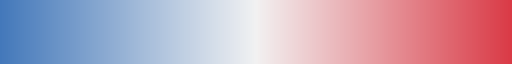

In [11]:
cmap = sns.diverging_palette(250, 10,as_cmap = True) 

cmap

In [12]:
bounds = np.array([-1.0, -0.8, -0.6, -0.4, 0.4, 0.6, 0.8, 1.0]) # 원하는 색상 경계 설정

norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

<AxesSubplot:>

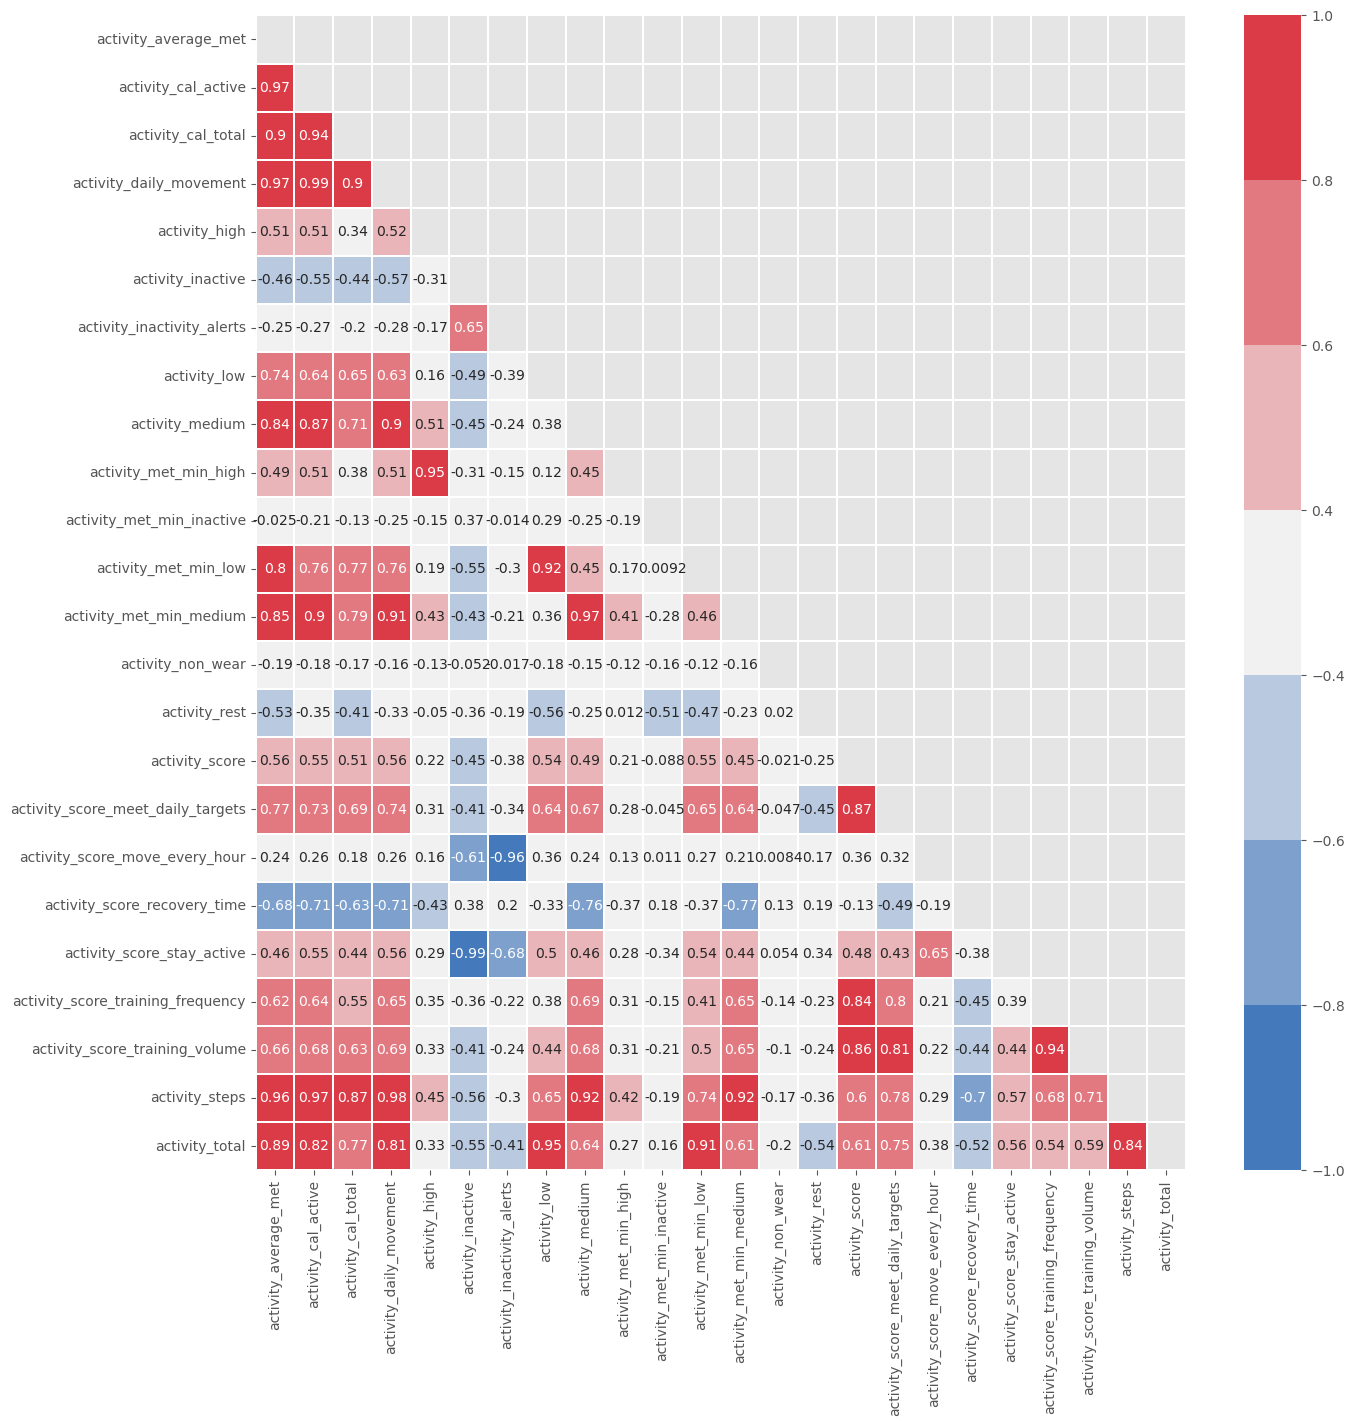

In [16]:
mask = np.triu(np.ones_like(X.corr()))

plt.figure(figsize = (15,15))

sns.heatmap(X.corr(), mask = mask , annot = True, cmap = cmap, norm = norm,
            linewidths = 0.1, fmt = '.2g')

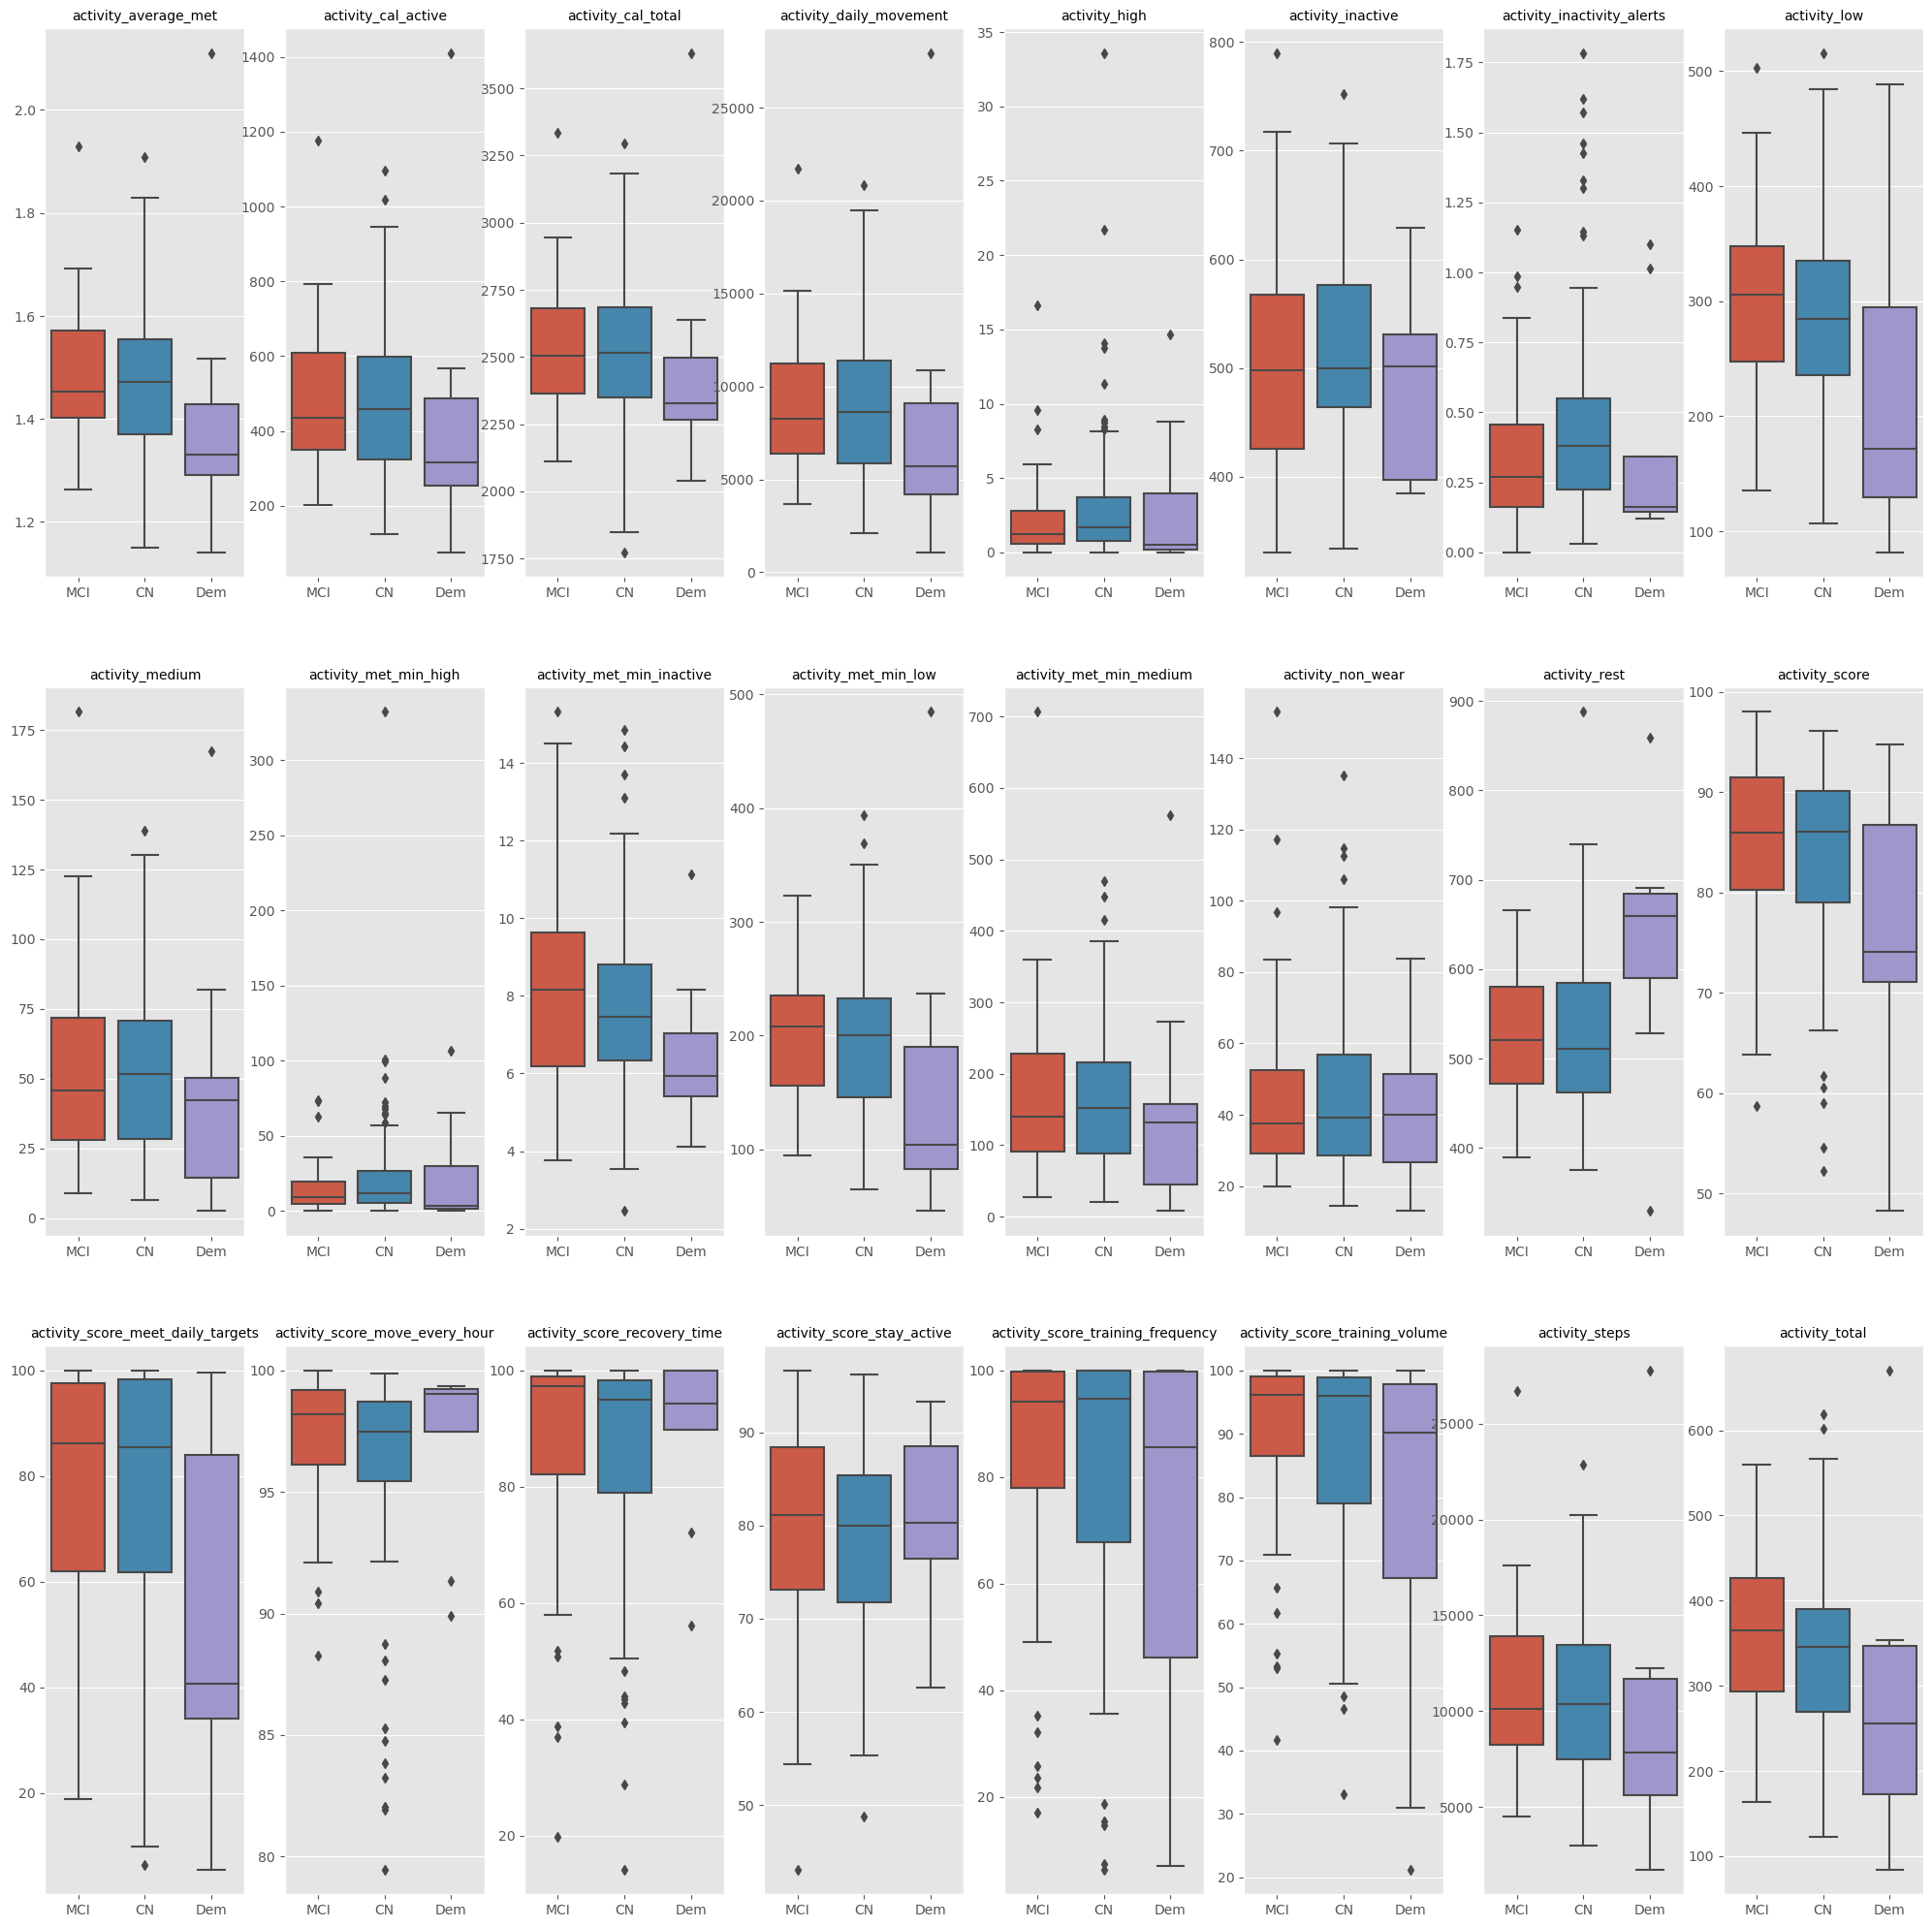

In [69]:
cols = df.columns.tolist()[:-1]

fig,ax = plt.subplots(ncols = 8,nrows=3, 
                        figsize = (25,25))

ax = ax.flatten()

for i,col in enumerate(cols):
    
    sns.boxplot(data = df,
                x = 'target',
                y = col,
                ax = ax[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].set_title(col, fontsize = 10)

* 차원 축소 후 데이터의 패턴을 보자 

In [32]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)

components = pca.fit_transform(X)

In [55]:
df['target'].unique()

target_colors = {'MCI':'orange','Dem':'red','CN':'green'}

color = df['target'].map(target_colors)

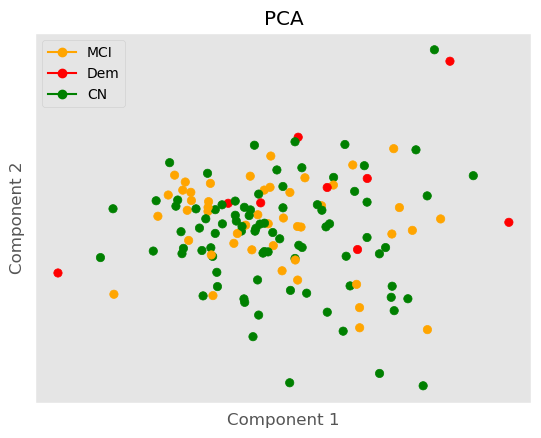

In [56]:
plt.scatter(components[:,0],
            components[:,1],
            color = color)

plt.xticks([])
plt.yticks([])
plt.title('PCA')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

legend_elements = [plt.Line2D([0], [0], marker='o', color=color, label=label) 
                   for label, color in target_colors.items()]

plt.legend(handles=legend_elements)

* 모든 변수를 가지고 차원 축소를 시행하니 비 치매환자, 경도 인지 장애, 치매 환자 간의 특성의 차이가 유의미하게 보이지 않았다.

* 아노바 테스트를 통해 그룹간의 차이가 유의미한 변수들을 찾아보자 

In [92]:
from sklearn.feature_selection import SelectKBest, f_classif

k = 5 # F-static이 가장 높은 K 개의 변수만 선택하겠다.
selector = SelectKBest(score_func=f_classif, k=k) # ANOVA test
X_new = selector.fit_transform(X, df['target']) # (독립변수 , 종속변수)

mask = selector.get_support() # Feature 들 중 F static 이 높은 상위 K 개만 True로 반출
selected_features = X.columns[mask] # Feature list 중 True 인 변수들만 선택 

print('mask : ', mask) 
print('\n')
print('selected_features : ', selected_features)

mask :  [False False False False False False False  True False False False False
 False False  True  True  True False False False False False False  True]


selected_features :  Index(['activity_low', 'activity_rest', 'activity_score',
       'activity_score_meet_daily_targets', 'activity_total'],
      dtype='object')


In [93]:
anova_test = pd.DataFrame({'Feature':X.columns,  
                            'F-static':selector.scores_,
                            'P-value':selector.pvalues_,}).sort_values(by = 'F-static',
                                                                        ascending = False).reset_index(drop = True)

anova_test # Anova test 결과

,Feature,F-static,P-value
0,activity_rest,5.741660,0.004025
1,activity_score_meet_daily_targets,5.343229,0.005820
2,activity_score,3.283238,0.040457
3,activity_low,3.255877,0.041528
4,activity_total,2.325390,0.101564
5,activity_score_training_volume,2.096684,0.126760
6,activity_inactivity_alerts,2.067916,0.130350
7,activity_score_move_every_hour,1.974946,0.142671
8,activity_met_min_inactive,1.617783,0.202077
9,activity_met_min_low,1.297965,0.276400


In [96]:
from sklearn.decomposition import PCA
import plotly.graph_objs as go

pca = PCA(n_components = 3)

components = pca.fit_transform(X[selected_features])

# fig ,ax =plt.subplots(subplot_kw = {'projection': '3d'})

# ax.scatter(components[:,0],
#             components[:,1],
#             components[:,2],
#             color = color)

# ax.xticks([])
# ax.yticks([])
# ax.title('PCA')
# ax.xlabel('Component 1')
# ax.ylabel('Component 2')

# legend_elements = [ax.Line2D([0], [0], marker='o', color=color, label=label) 
#                     for label, color in target_colors.items()]

# fig.legend(handles=legend_elements)

size = 3

fig = go.Figure(data=[go.Scatter3d(x=components[:,0], y=components[:,1], z=components[:,2], mode='markers', marker=dict(color=color, size=size))])

# Customize the plot
fig.update_layout(scene=dict(xaxis_title='X Axis', yaxis_title='Y Axis', zaxis_title='Z Axis'),
                  width=500, height=500, margin=dict(l=0, r=0, b=0, t=0))

# Show the plot
fig.show()

* 아노바 테스트를 통해 그룹간 차이가 가장 유의미한 변수 5개만 골라 차원 축소 후 데이터를 살펴보았지만 비 치매군과 치매 군의 유의미한 데이터 패턴을 찾지 못하겠다.

# 모델링

In [155]:
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras import callbacks

* target 데이터의 불균형이 심하니 학습할 때는 오버샘플링을 시행하도록 하자 

In [166]:
def over_sampling(train,target, k):
    
    sampling = SMOTE(k_neighbors = k)
    
    over_train_x, over_train_y = sampling.fit_resample(train,target)
    
    return over_train_x,over_train_y

In [173]:
def one_hot_encoder(target):
    
    enc = LabelEncoder()
    
    target = enc.fit_transform(target)
    
    target = tf.one_hot(target,depth = 3)
    
    return pd.DataFrame(target)

In [174]:
def create_dnn(INPUT_SHAPE,
                FIRST_NODE,
                ALPHA,
                LAYERS,
                HIDDEN_NODE,
                DROPOUT_RATE):
    
    inputs = layers.Input(shape = INPUT_SHAPE)
    
    x = layers.BatchNormalization()(inputs)
    x = layers.Dense(units = FIRST_NODE, activation = layers.LeakyReLU(alpha = ALPHA),
                                kernel_initializer = initializers.HeNormal())(x)
    x = layers.Dropout(DROPOUT_RATE)(x)
    
    for _ in range(LAYERS):
        
        x = layers.BatchNormalization()(x)    
        x = layers.Dense(units = HIDDEN_NODE, activation = layers.LeakyReLU(alpha = ALPHA),
                                kernel_initializer = initializers.HeNormal())(x)
        x = layers.Dropout(DROPOUT_RATE)(x)
        
    x = layers.BatchNormalization()(x)
    
    outputs = layers.Dense(3, activation = 'softmax',
                                kernel_initializer = initializers.GlorotNormal())(x)
    
    return keras.Model(inputs,outputs)        

In [193]:
params= {'INPUT_SHAPE':X.shape[1:],
        'FIRST_NODE':32,
        'ALPHA':0.01,
        'LAYERS':10,
        'HIDDEN_NODE':16,
        'DROPOUT_RATE':0.7}

optimizers = {'loss': 'categorical_crossentropy',
                'optimizer': tf.optimizers.legacy.Adam(learning_rate=0.01),
                'metrics': ['accuracy']}

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 50)

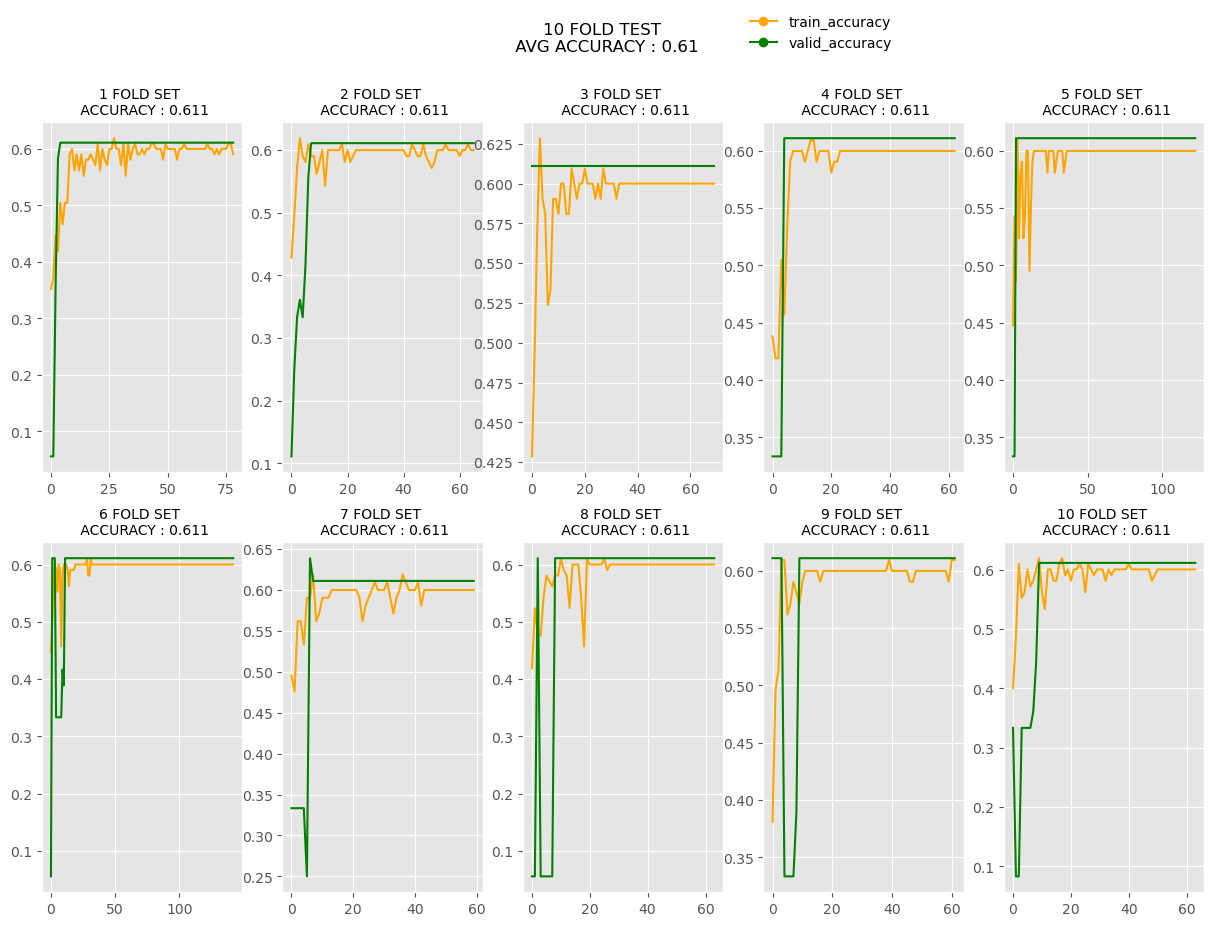

In [194]:
REPEATE = 10

fig,ax = plt.subplots(ncols = 5, nrows = 2, 
                        figsize = (15,10))
ax = ax.flatten()

X = df.drop('target',axis = 1)
Y = df['target']
    
avg_score = 0    

for i in range(REPEATE):
    

    x_train,x_test,y_train,y_test = train_test_split(X,Y,random_state = 42 + i, stratify = Y)
    
    y_train , y_test = one_hot_encoder(y_train),one_hot_encoder(y_test)
    
    model = create_dnn(**params)
    model.compile(**optimizers) 
    
    history = model.fit(x_train,y_train,
                validation_data = (x_test,y_test),
                epochs = 9999,
                callbacks = [early_stopping],
                verbose = 0)
    
    score = model.evaluate(x_test,y_test,verbose = 0)[-1]
    
    avg_score += score / REPEATE
    
    ax[i].plot(history.history['accuracy'], c = 'orange',label = 'train_accuracy')
    ax[i].plot(history.history['val_accuracy'], c = 'green',label = 'valid_accuracy')
    
    ax[i].set_title(f'{i + 1} FOLD SET \n ACCURACY : {round(score,3)}', fontsize = 10)
    
    
fig.suptitle(f'10 FOLD TEST \n AVG ACCURACY : {round(avg_score,2)}')


color = ['orange','green']
label = ['train_accuracy','valid_accuracy']
legend_color = {'train_accuracy':'orange','valid_accuracy':'green'}


legend_elements = [plt.Line2D([0], [0], marker='o', color=color, label=label) 
                    for label, color in legend_color.items()]

fig.legend(handles=legend_elements,
            bbox_to_anchor = (0.7,1),
            frameon = False)


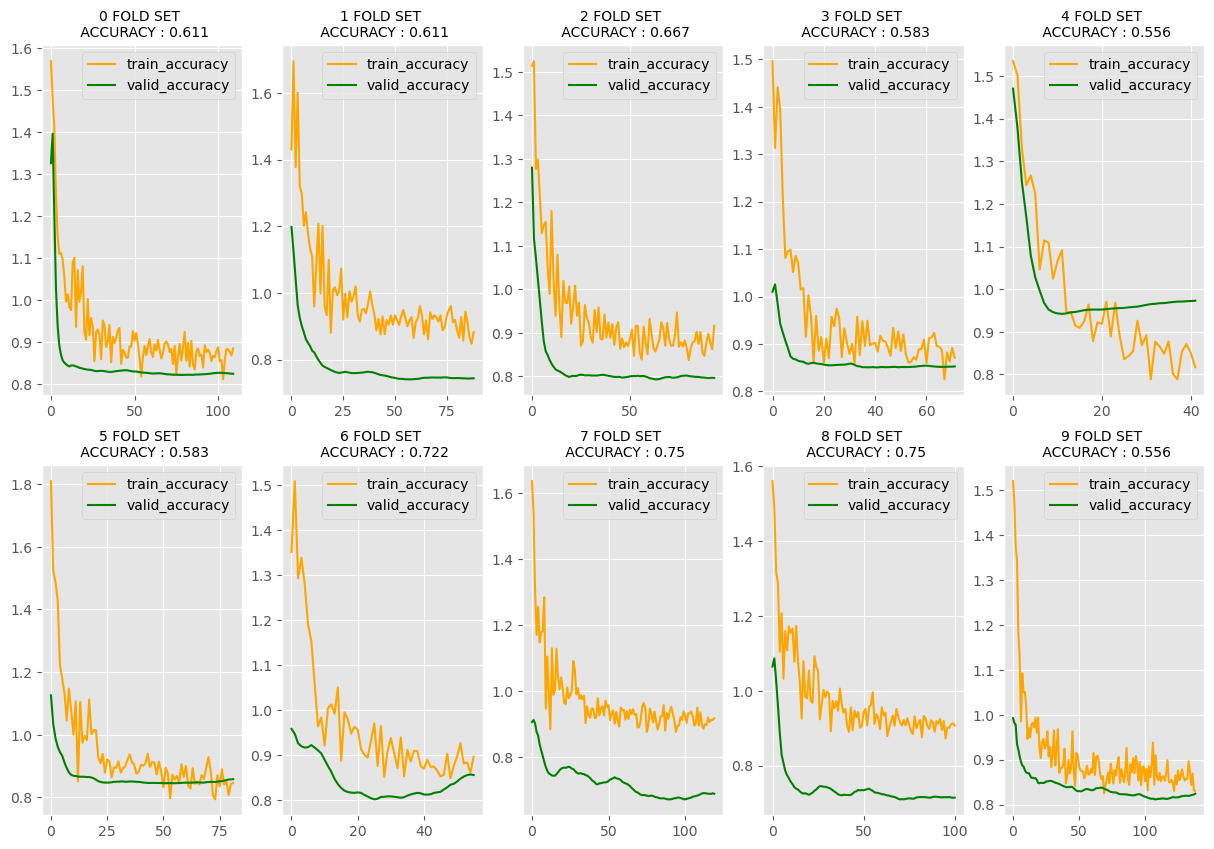

In [150]:
REPEATE = 10


params= {'INPUT_SHAPE':X[selected_features].shape[1:],
        'FIRST_NODE':128,
        'ALPHA':0.01,
        'LAYERS':5,
        'HIDDEN_NODE':32,
        'DROPOUT_RATE':0.5}

fig,ax = plt.subplots(ncols = 5, nrows = 2, 
                        figsize = (15,10))
ax = ax.flatten()

for i in range(REPEATE):
    
    x_train,x_test,y_train,y_test = train_test_split(X[selected_features],Y,random_state = 42 + i)
    
    model = create_dnn(**params)
    model.compile(**optimizers) 
    
    history = model.fit(x_train,y_train,
                validation_data = (x_test,y_test),
                epochs = 9999,
                callbacks = [early_stopping],
                verbose = 0)
    
    score = model.evaluate(x_test,y_test,verbose = 0)[-1]
    
    ax[i].plot(history.history['loss'], c = 'orange',label = 'train_accuracy')
    ax[i].plot(history.history['val_loss'], c = 'green',label = 'valid_accuracy')
    ax[i].legend()
    
    ax[i].set_title(f'{i} FOLD SET \n ACCURACY : {round(score,3)}', fontsize = 10)